In [1]:
!pip install --upgrade torch transformers pandas scikit-learn tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# 3. Load and combine all CSVs from the preprocessed datasets folder
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from tqdm import tqdm

data_dir = 'Datasets/Preprocessed Datasets'
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)
print(df.head())

# 4. Prepare data
X = df['answer_item_1'].astype(str)
y = df['topic'].astype('category').cat.codes
label2topic = dict(enumerate(df['topic'].astype('category').cat.categories))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Tokenize with BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# 6. PyTorch Dataset
class TopicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TopicDataset(train_encodings, y_train)
test_dataset = TopicDataset(test_encodings, y_test)

# 7. Define BERT model and training arguments
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label2topic))

# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=2,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     evaluation_strategy='epoch',
#     save_strategy='no',
#     logging_dir='./logs',
#     logging_steps=10,
#     report_to='none'
# )

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 8. Train the model and measure training time
import time
start_time = time.time()
trainer.train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

# 9. Evaluate Model Performance
preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=[label2topic[i] for i in range(len(label2topic))]))

import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label2topic.values(), yticklabels=label2topic.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 10. Example Input-Output
example = "How do I create a virtual environment in Python?"
inputs = tokenizer(example, return_tensors="pt", truncation=True, padding=True, max_length=128)
with torch.no_grad():
    logits = model(**inputs).logits
    pred_label = logits.argmax(dim=1).item()
    print(f"Input: {example}")
    print(f"Predicted topic: {label2topic[pred_label]}")

   Unnamed: 0  question_id                                      question_text  \
0           0            1  ['organ', 'choos', 'concern', 'eye', 'stage', ...   
1           1            2  ['certainli', 'turn', 'marriag', 'consid', 'en...   
2           2            3       ['marriag', 'best', 'film', 'dream', 'wish']   
3           3            4  ['guess', 'soon', 'hair', 'compani', 'letter',...   
4           4            5  ['know', 'say', 'congress', 'view', 'wear', 'a...   

                   topic                                      answer_item_1  \
0  ['quantum', 'comput']       ['detail', 'well', 'window', 'join', 'peac']   
1    ['climat', 'chang']               ['articl', 'hous', 'perform', 'run']   
2          ['psycholog']  ['serv', 'one', 'news', 'get', 'appli', 'true'...   
3            ['histori']  ['financi', 'import', 'catch', 'decad', 'well'...   
4    ['machin', 'learn']  ['color', 'happi', 'beat', 'third', 'ok', 'rel...   

                                      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [3]:
!pip install --upgrade transformers

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# !pip install --upgrade "accelerate>=0.26.0" "transformers>=4.38.0" torch
!pip install --upgrade "transformers[torch]" accelerate

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# 1. Import Libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Check and install required dependencies
# If you encounter ImportError for accelerate, run:
# !pip install --upgrade transformers torch accelerate

# 3. Load and combine all CSVs from the preprocessed datasets folder
data_dir = 'Datasets/Preprocessed Datasets'
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)
print(df.head())

# 4. Prepare data
X = df['answer_item_1'].astype(str)
y = df['topic'].astype('category').cat.codes
label2topic = dict(enumerate(df['topic'].astype('category').cat.categories))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Tokenize with BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# 6. PyTorch Dataset
class TopicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TopicDataset(train_encodings, y_train)
test_dataset = TopicDataset(test_encodings, y_test)

# 7. Define BERT model and training arguments
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(label2topic)
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    report_to='none'  # disables wandb or other logging, safe for local
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 8. Train the model and measure training time
start_time = time.time()
trainer.train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

# 9. Evaluate Model Performance
preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(
    y_test, y_pred, 
    target_names=[label2topic[i] for i in range(len(label2topic))]
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label2topic.values(), 
    yticklabels=label2topic.values()
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 10. Example Input-Output
example = "How do I create a virtual environment in Python?"
inputs = tokenizer(example, return_tensors="pt", truncation=True, padding=True, max_length=128)
with torch.no_grad():
    logits = model(**inputs).logits
    pred_label = logits.argmax(dim=1).item()
    print(f"Input: {example}")
    print(f"Predicted topic: {label2topic[pred_label]}")

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Unnamed: 0  question_id                                      question_text  \
0           0            1  ['organ', 'choos', 'concern', 'eye', 'stage', ...   
1           1            2  ['certainli', 'turn', 'marriag', 'consid', 'en...   
2           2            3       ['marriag', 'best', 'film', 'dream', 'wish']   
3           3            4  ['guess', 'soon', 'hair', 'compani', 'letter',...   
4           4            5  ['know', 'say', 'congress', 'view', 'wear', 'a...   

                   topic                                      answer_item_1  \
0  ['quantum', 'comput']       ['detail', 'well', 'window', 'join', 'peac']   
1    ['climat', 'chang']               ['articl', 'hous', 'perform', 'run']   
2          ['psycholog']  ['serv', 'one', 'news', 'get', 'appli', 'true'...   
3            ['histori']  ['financi', 'import', 'catch', 'decad', 'well'...   
4    ['machin', 'learn']  ['color', 'happi', 'beat', 'third', 'ok', 'rel...   

                                      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ValueError: Target size (torch.Size([8])) must be the same as input size (torch.Size([8, 20]))

Sample data:
   Unnamed: 0  question_id                                      question_text  \
0           0            1  ['organ', 'choos', 'concern', 'eye', 'stage', ...   
1           1            2  ['certainli', 'turn', 'marriag', 'consid', 'en...   
2           2            3       ['marriag', 'best', 'film', 'dream', 'wish']   
3           3            4  ['guess', 'soon', 'hair', 'compani', 'letter',...   
4           4            5  ['know', 'say', 'congress', 'view', 'wear', 'a...   

                   topic                                      answer_item_1  \
0  ['quantum', 'comput']       ['detail', 'well', 'window', 'join', 'peac']   
1    ['climat', 'chang']               ['articl', 'hous', 'perform', 'run']   
2          ['psycholog']  ['serv', 'one', 'news', 'get', 'appli', 'true'...   
3            ['histori']  ['financi', 'import', 'catch', 'decad', 'well'...   
4    ['machin', 'learn']  ['color', 'happi', 'beat', 'third', 'ok', 'rel...   

                         

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,3.110700
20,3.022300
30,3.007300
40,3.053300
50,3.030900
60,3.034400
70,3.035700
80,3.031700
90,3.005100
100,3.008900


Training time: 1209.82 seconds


C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Test Accuracy: 0.0750

Classification Report:
                    precision    recall  f1-score   support

 artifici intellig       0.07      1.00      0.13        14
        blockchain       0.20      0.09      0.12        11
    career develop       0.00      0.00      0.00        10
      climat chang       0.00      0.00      0.00        12
        cybersecur       0.00      0.00      0.00         9
       data scienc       0.00      0.00      0.00         8
      digit market       0.00      0.00      0.00         9
              educ       0.00      0.00      0.00         9
  entrepreneurship       0.00      0.00      0.00         9
environment scienc       0.00      0.00      0.00         9
        health fit       0.00      0.00      0.00        11
           histori       0.00      0.00      0.00        10
      machin learn       0.00      0.00      0.00         9
     person financ       0.00      0.00      0.00        13
         psycholog       0.00      0.00      0.00   

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

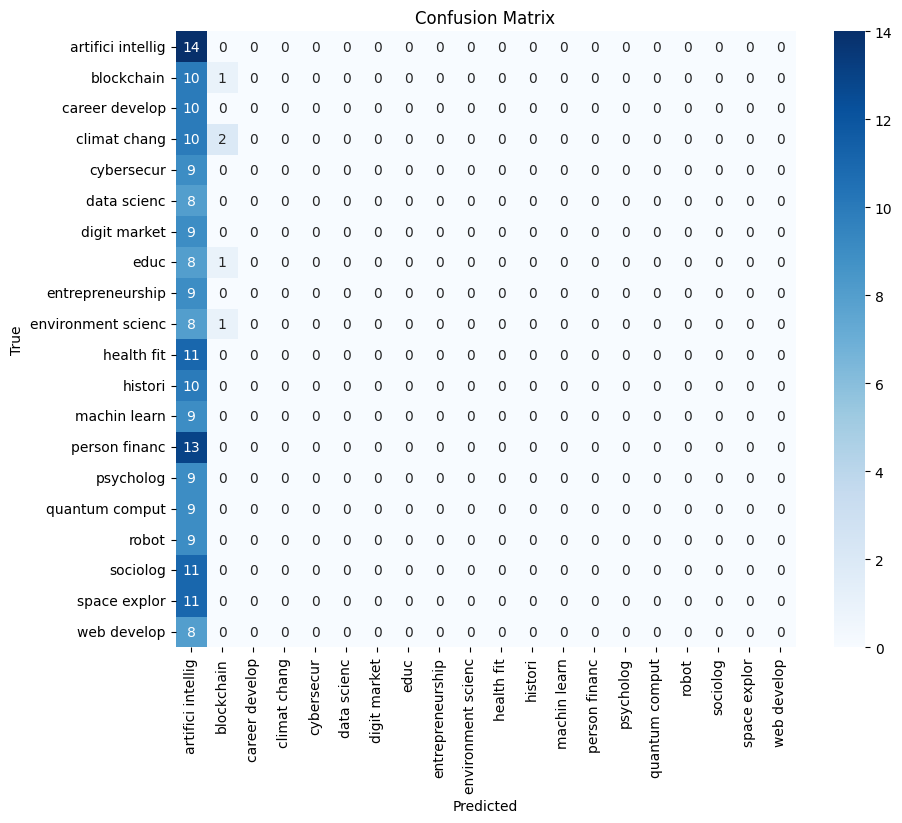


Example Input: How do I create a virtual environment in Python?
Predicted topic: artifici intellig


In [3]:
# 1. Import Libraries
import os
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns

# 2. (If needed) Install dependencies:
# !pip install --upgrade transformers torch accelerate

# 3. Load and combine all CSVs from the preprocessed datasets folder
data_dir = 'Datasets/Preprocessed Datasets'
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)
print("Sample data:")
print(df.head())

# 4. Prepare data - FIX for stringified list in 'topic'
def topic_to_str(x):
    # Handles: ['quantum', 'comput'] -> "quantum computing"
    if isinstance(x, str) and x.startswith('['):
        try:
            lst = ast.literal_eval(x)
            return " ".join(lst)
        except:
            return x
    return str(x)

df['topic_str'] = df['topic'].apply(topic_to_str)
y = df['topic_str'].astype('category').cat.codes
label2topic = dict(enumerate(df['topic_str'].astype('category').cat.categories))
# Use answer_item_1 as text input; if it's a list, join tokens
def ans1_to_str(x):
    if isinstance(x, str) and x.startswith('['):
        try:
            lst = ast.literal_eval(x)
            return " ".join(lst)
        except:
            return x
    return str(x)
X = df['answer_item_1'].apply(ans1_to_str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Tokenize with BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# 6. PyTorch Dataset
# class TopicDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels.reset_index(drop=True)
#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels.iloc[idx])
#         return item
#     def __len__(self):
#         return len(self.labels)

class TopicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Ensure label is int and torch.long
        item['labels'] = torch.tensor(int(self.labels.iloc[idx]), dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)


train_dataset = TopicDataset(train_encodings, y_train)
test_dataset = TopicDataset(test_encodings, y_test)

# 7. Define BERT model and training arguments
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(label2topic)
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 8. Train the model and measure training time
start_time = time.time()
trainer.train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

# 9. Evaluate Model Performance
preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred, 
    target_names=[label2topic[i] for i in range(len(label2topic))]
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label2topic.values(), 
    yticklabels=label2topic.values()
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 10. Example Input-Output
example = "How do I create a virtual environment in Python?"
inputs = tokenizer(example, return_tensors="pt", truncation=True, padding=True, max_length=128)
with torch.no_grad():
    logits = model(**inputs).logits
    pred_label = logits.argmax(dim=1).item()
    print(f"\nExample Input: {example}")
    print(f"Predicted topic: {label2topic[pred_label]}")